## ATAC + MULTIOME FEMALES (april 2021)

### Convert to Seurat objects for CICERO

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata


/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.20.0
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_res

In [5]:
print(anndata2ri.__version__)
print(anndata.__version__)

1.0.6
0.7.5


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(Signac)
library(Seurat)
library(SeuratDisk)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

For future reference most packages were installed here: */tmp/RtmpGjkK1o/downloaded_packages/*

**Set directories**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/"
experiment_prefix = 'females_'

#### Convert the h5ad created with cisTopic into a Seurat object with peaks assay

In [9]:
ATAC_scanpy = sc.read_h5ad(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
ATAC_scanpy

AnnData object with n_obs × n_vars = 67202 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf', 'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP', 'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV', 'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune', 'M_MullDuct_LGR5', 'max', 'dualRNA_label', 'leiden_R', 'cell_type'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellat

In [10]:
ATAC_scanpy.X

<67202x201343 sparse matrix of type '<class 'numpy.float32'>'
	with 261980605 stored elements in Compressed Sparse Row format>

In [11]:
binary_raw = ATAC_scanpy.layers['binary_raw']
binary_raw

<67202x201343 sparse matrix of type '<class 'numpy.float32'>'
	with 261980605 stored elements in Compressed Sparse Row format>

In [12]:
binary_raw.shape

(67202, 201343)

Step 1: from sparse matrix (python format) to dgcMatrix (R format)

I found this function here: <https://github.com/theislab/anndata2ri/issues/8>

In [13]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [14]:
ATAC_R = csr_to_dgc(binary_raw)
ATAC_R

<rpy2.robjects.methods.RS4 object at 0x7f9e3cbbf340> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [15]:
%%R -i ATAC_R -o ATAC_dgT

ATAC_dgT <- as(ATAC_R, "dgTMatrix")
print(dim(ATAC_dgT)) # Check the shape of the matrix 

[1] 201343  67202


Step 2: save metadata per cell and per peak and add colnames and rownames to the peak matrix

In [16]:
metadata_cell = ATAC_scanpy.obs
metadata_peak = ATAC_scanpy.var
layers = ATAC_scanpy.layers
reduction_cistopic = ATAC_scanpy.obsm['X_cistopic_40']
reduction_umap = ATAC_scanpy.obsm['X_umap']
reduction_harmony = ATAC_scanpy.obsm['X_harmony']

In [17]:
del ATAC_scanpy.obs['cellatac_clusters']

In [18]:
%%R -i ATAC_dgT -i metadata_cell -i metadata_peak 

rownames(ATAC_dgT) <- rownames(metadata_peak) # Add rownames to peak matrix
colnames(ATAC_dgT) <- rownames(metadata_cell) # Add colnames to peak matrix 

In [19]:
%%R 
print(head(rownames(ATAC_dgT)))
print(head(colnames(ATAC_dgT)))
print(names(ATAC_dgT))

[1] "chr1:816836-817441" "chr1:817738-818526" "chr1:825667-826063"
[4] "chr1:826596-827809" "chr1:858468-859047" "chr1:869401-870252"
[1] "01-AAACGAAAGGCTCCTG-1" "01-AAACGAAAGTCCAGAG-1" "01-AAACGAACACCCATCT-1"
[4] "01-AAACGAACAGGTCTGC-1" "01-AAACGAACATAGCCAT-1" "01-AAACGAAGTAGCATGG-1"
NULL


Step 3: build ChromatinAssay with peaks x cells matrix 

In [20]:
%%R -o chrom_assay 

 chrom_assay <- CreateChromatinAssay(
    counts = ATAC_dgT,
    sep = c(":", "-"),
    genome = "hg38",
    ranges = NULL,
 )
chrom_assay

ChromatinAssay data with 201343 features for 67202 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 


Step 4: build Seurat object from chromatin assay 

In [21]:
%%R -o ATAC_Seurat -i metadata_cell

ATAC_Seurat <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = metadata_cell,
  )
ATAC_Seurat

An object of class Seurat 
201343 features across 67202 samples within 1 assay 
Active assay: peaks (201343 features, 0 variable features)


In [22]:
%%R 
print(table(ATAC_Seurat@meta.data$individual))
print(table(ATAC_Seurat@meta.data$leiden))


  F81 Hrv11 Hrv12 Hrv13 Hrv39 Hrv49 Hrv50 Hrv58 Hrv59 
 8553  1163  3391  4674 10451  8586 20240  4912  5232 

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7042 6881 6815 5322 5262 4591 3988 3595 3496 3383 3165 2856 2529 1598  895  840 
  16   17   18   19   20   21   22   23 
 818  806  778  732  615  517  420  258 


Step 5: Add dimensionality reductions to Seurat object 

In [23]:
%%R -i reduction_cistopic -i metadata_cell -o reduction_cistopic_2 

reduction_cistopic_2 <- data.matrix(reduction_cistopic)
key <- "cisTopic_"
colnames(reduction_cistopic_2) <- paste0(key, 1:ncol(x = reduction_cistopic_2))
rownames(reduction_cistopic_2) <- rownames(metadata_cell)
#print(head(reduction_cistopic_2))

In [24]:
%%R -i reduction_umap -i metadata_cell -o reduction_umap_2 

reduction_umap_2 <- data.matrix(reduction_umap)
key2 <- "UMAP_"
colnames(reduction_umap_2) <- paste0(key2, 1:ncol(x = reduction_umap_2))
rownames(reduction_umap_2) <- rownames(metadata_cell)
#print(head(reduction_umap_2))

In [25]:
%%R -i reduction_harmony -i metadata_cell -o reduction_harmony_2 

reduction_harmony_2 <- data.matrix(reduction_harmony)
key3 <- "Harmony_"
colnames(reduction_harmony_2) <- paste0(key3, 1:ncol(x = reduction_harmony_2))
rownames(reduction_harmony_2) <- rownames(metadata_cell)
#print(head(reduction_harmony_2))

In [26]:
%%R 

ATAC_Seurat@reductions$cisTopics <- CreateDimReducObject(embeddings = reduction_cistopic_2, assay = "peaks")
ATAC_Seurat@reductions$umap <- CreateDimReducObject(embeddings = reduction_umap_2, assay = "peaks")
ATAC_Seurat@reductions$harmony <- CreateDimReducObject(embeddings = reduction_harmony_2, assay = "peaks")
ATAC_Seurat

An object of class Seurat 
201343 features across 67202 samples within 1 assay 
Active assay: peaks (201343 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


### Save RDS object of females 

In [27]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat, file = paste0(outdir, experiment_prefix, "_full.rds"))

In [10]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat <- readRDS(file = paste0(outdir, experiment_prefix, "_full.rds"))

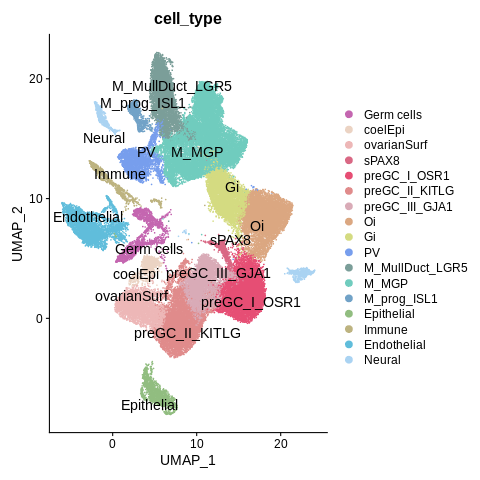

In [28]:
%%R 

gonads_colors = c('#c466b0', '#ebd3c3',  '#edb7b7','#d96884','#e64e74','#e08b8b', '#d9abb7', '#dba781',
     '#d4db81','#779eed', '#7b9e99', 
 '#70ccbe',   '#71a2c7','#91bd80',  '#bdb380','#60bddb',
    '#aad3f2')
DimPlot(object = ATAC_Seurat, group.by = "cell_type", label = TRUE, repel = TRUE,
        label.size = 5, cols = gonads_colors)

## TF motifs with ChromVar

#### Add motifs

In [29]:
%%R -o pfm

# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv10')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}


# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
#print(names(pfmHOMER))
names(pfmHOMER)[93] = "FOXL2.HOMER"
 
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)
#print(names(pfmHOMER))

for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}


# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
}

# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

[1] 638 147 683


#### Add motifs

In [30]:
%%R -o ATAC_Seurat_withMotifs

ATAC_Seurat_withMotifs <- AddMotifs(object = ATAC_Seurat, 
                         genome= BSgenome.Hsapiens.UCSC.hg38, 
                         pfm = pfm, 
                         assay = "peaks", 
                         verbose = TRUE)

ATAC_Seurat_withMotifs

An object of class Seurat 
201343 features across 67202 samples within 1 assay 
Active assay: peaks (201343 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


#### Compute per-cell motif activity scores with chromVar

In [31]:
%%R -o ATAC_Seurat_withChromVar

library(BiocParallel)
register(SerialParam())
ATAC_Seurat_withChromVar <- RunChromVAR(
  object = ATAC_Seurat_withMotifs,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  assay="peaks"
)
ATAC_Seurat_withChromVar

An object of class Seurat 
203263 features across 67202 samples within 2 assays 
Active assay: peaks (201343 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [32]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat_withChromVar, file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))

In [33]:
%%R -i pfm -o motif2names

library(dplyr) 
motif2names <- lapply(pfm, function(x) x@name)
names(motif2names) <- sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [34]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [36]:
%%R 

Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$cell_type
print(table(Idents(ATAC_Seurat_withChromVar)))


     Germ cells         coelEpi     ovarianSurf           sPAX8    preGC_I_OSR1 
           1618             895            3496             615            6881 
 preGC_II_KITLG  preGC_III_GJA1              Oi              Gi              PV 
           7300            4591            6815            5262            2529 
M_MullDuct_LGR5           M_MGP     M_prog_ISL1      Epithelial          Immune 
           5322           14131             806            1598             818 
    Endothelial          Neural 
           3588             937 


In [37]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(ATAC_Seurat_withChromVar, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'TFs/DARs/all_DA_peaks_LR.csv'))

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~27m 28s       |++                                                | 2 % ~28m 24s       |++                                                | 3 % ~27m 04s       |+++                                               | 4 % ~25m 30s       |+++                                               | 5 % ~24m 59s       |++++                                              | 6 % ~23m 52s       |++++                                              | 7 % ~23m 36s       |+++++                                             | 8 % ~22m 59s       |+++++                                             | 9 % ~22m 34s       |++++++                                            | 10% ~22m 21s       |++++++                                            | 11% ~22m 01s       |+++++++                                           | 12% ~21m 43s       |+++++++                                           | 14% ~21m 

#### z-scores per cell type annotation

In [61]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar <- readRDS(file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))
DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 
ATAC_Seurat_withChromVar

An object of class Seurat 
203263 features across 67202 samples within 2 assays 
Active assay: chromvar (1920 features, 0 variable features)
 1 other assay present: peaks
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [62]:
%%R -o chromvar_assay

chromvar_assay <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_Seurat_withChromVar))))

In [63]:
chromvar_assay.shape

(67202, 1920)

In [64]:
# Mapping of cells to cell types 
ATAC_scanpy.obs['barcode'] = ATAC_scanpy.obs_names
cells_celltypes = ATAC_scanpy.obs[['barcode', 'cell_type']]
cells_celltypes.head()

,barcode,cell_type
01-AAACGAAAGGCTCCTG-1,01-AAACGAAAGGCTCCTG-1,preGC_I_OSR1
01-AAACGAAAGTCCAGAG-1,01-AAACGAAAGTCCAGAG-1,preGC_I_OSR1
01-AAACGAACACCCATCT-1,01-AAACGAACACCCATCT-1,ovarianSurf
01-AAACGAACAGGTCTGC-1,01-AAACGAACAGGTCTGC-1,preGC_I_OSR1
01-AAACGAACATAGCCAT-1,01-AAACGAACATAGCCAT-1,Gi


In [65]:
cells_mapping_clusters = cells_celltypes.groupby('cell_type').groups

In [66]:
# Mean by rows 
for key in cells_mapping_clusters: 
    print(key)
    chromvar_assay.loc[key] = chromvar_assay.loc[cells_mapping_clusters[key]].mean(axis = 0)

Germ cells
coelEpi
sPAX8
preGC_I_OSR1
ovarianSurf
preGC_II_KITLG
preGC_III_GJA1
Oi
Gi
M_prog_ISL1
M_MGP
M_MullDuct_LGR5
PV
Epithelial
Endothelial
Immune
Neural


In [67]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
chromvar_assay = chromvar_assay.loc[rows_celltypes, ]

['Endothelial', 'Epithelial', 'Germ cells', 'Gi', 'Immune', 'M_MGP', 'M_MullDuct_LGR5', 'M_prog_ISL1', 'Neural', 'Oi', 'PV', 'coelEpi', 'ovarianSurf', 'preGC_III_GJA1', 'preGC_II_KITLG', 'preGC_I_OSR1', 'sPAX8']


In [68]:
# Normalize by column (TF)
from scipy.stats import zscore
chromvar_assay_zscore = chromvar_assay.apply(zscore)

In [69]:
chromvar_assay_zscore.to_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv")

In [70]:
chromvar_assay_zscore = chromvar_assay_zscore.reindex(['Germ cells',
                                                 'coelEpi',  'sPAX8', 'preGC_I_OSR1',
                                                 'ovarianSurf','preGC_II_KITLG', 'preGC_III_GJA1',
                                                  'Oi',  'Gi', 
                                                 'M_prog_ISL1', 'M_MGP', 'M_MullDuct_LGR5', 
                                                 'PV','Epithelial', 'Endothelial', 'Immune', 'Neural'
                                          ])


In [93]:
import seaborn as sns
my_cmap = sns.diverging_palette(240, 10, s = 100, l = 40,n=10, as_cmap=True)


In [22]:
chromvar_assay_zscore.shape

(17, 1920)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


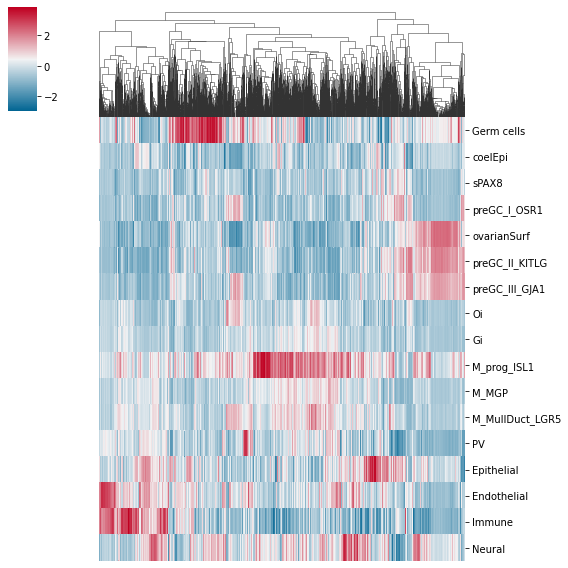

In [23]:
heatmap_TFs = sns.clustermap(chromvar_assay_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = my_cmap)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_TFs.pdf")


### Select top 3 TFs per cell type 

In [56]:
top_tfs = []
for c in chromvar_assay_zscore.index:
    df_c = chromvar_assay_zscore.loc[c]
    df_c = df_c.sort_values(axis = 0, ascending = False)
    top_4 = df_c[0:5].index
    top_tfs.extend(top_4)

In [57]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore[top_tfs]

In [58]:
chromvar_assay_zscore_top4.columns

Index(['NFYA.MA0060.3', 'DMRT6.HOMER', 'NFYB.MA0502.1', 'CEBPZ.SwissRegulon',
       'TFAP2D.SwissRegulon', 'EGR2.SwissRegulon', 'PROX1-HUMAN.H10MO.D',
       'TEAD4-HUMAN.H10MO.A', 'HLF-HUMAN.H10MO.C', 'HLF.SwissRegulon',
       'EGR1.SwissRegulon', 'EGR2.MA0472.2', 'PAX1.MA0779.1', 'PAX9.MA0781.1',
       'EGR1-HUMAN.H10MO.S', 'ID4-HUMAN.H10MO.D', 'SMAD4-HUMAN.H10MO.C',
       'MESP1.SwissRegulon', 'SMAD2-HUMAN.H10MO.C', 'TCF3.MA0522.2',
       'MNX1.MA0707.1', 'VSX1.MA0725.1', 'VSX2.MA0726.1', 'MEOX2.MA0706.1',
       'GSX2.MA0893.1', 'SF1.HOMER', 'ESRRB.MA0141.3', 'HXD3-HUMAN.H10MO.D',
       'ERR2-HUMAN.H10MO.A', 'PPARA.SwissRegulon', 'NR4A2::RXRA.MA1147.1',
       'NR1A4::RXRA.MA1146.1', 'FOXF2.MA0030.1', 'FOXG1.MA0613.1',
       'FOXB1.SwissRegulon', 'MSC.MA0665.1', 'TFAP4.MA0691.1',
       'MSC.SwissRegulon', 'TFAP4-HUMAN.H10MO.C', 'NHLH1.MA0048.2',
       'ARNT::HIF1A.MA0259.1', 'OLIG1.SwissRegulon', 'HIF1A.MA1106.1',
       'NR3C2.SwissRegulon', 'BHLHE22.SwissRegulon', 'HOXC1

In [59]:
to_plot = ['DMRT6.HOMER', 'EGR2.SwissRegulon', 'PAX1.MA0779.1', 'FOXF2.MA0030.1','MNX1.MA0707.1', 
            'MESP1.SwissRegulon',  'TCF3.MA0522.2',  'MSC.SwissRegulon','OLIG1.SwissRegulon','HOXC13.MA0907.1',
             'HSF2.MA0770.1', 'TWIST1.MA1123.1','EBF3.SwissRegulon',
           'HNF1B.MA0153.2', 'FLI1.SwissRegulon', 'SPI1.MA0080.4', 'RFX3.SwissRegulon',
           ]
len(to_plot)

17

In [60]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore_top4[to_plot]
chromvar_assay_zscore_top4.columns

Index(['DMRT6.HOMER', 'EGR2.SwissRegulon', 'PAX1.MA0779.1', 'FOXF2.MA0030.1',
       'MNX1.MA0707.1', 'MESP1.SwissRegulon', 'TCF3.MA0522.2',
       'MSC.SwissRegulon', 'OLIG1.SwissRegulon', 'HOXC13.MA0907.1',
       'HSF2.MA0770.1', 'TWIST1.MA1123.1', 'EBF3.SwissRegulon',
       'HNF1B.MA0153.2', 'FLI1.SwissRegulon', 'SPI1.MA0080.4',
       'RFX3.SwissRegulon'],
      dtype='object')

In [61]:
chromvar_assay_zscore_top4.columns = [col.split(".")[0] for col in chromvar_assay_zscore_top4.columns]

In [91]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


<ipython-input-91-63a9665b3b7d>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


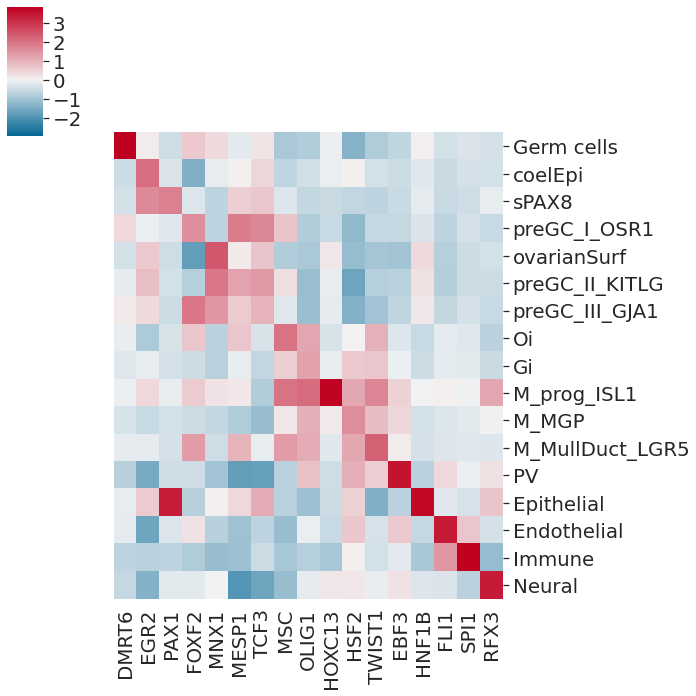

In [63]:
sns.set(font_scale=1.8)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_top4, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(10, 10),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_TFs_top1_curated.pdf")


### Plot TFs associated with DSD

In [59]:
dsd_tfs = ['ARX', 'ATRX', 'BMP15', 'CBX2', 'DAX1', 'DHH', 'DHX37', 'DMRT1', 'EMX2', 'ESR2', 'FGF9', 'FGFR2', 'FOXL2',
          'GATA4', 'HHAT', 'MAP3K1', 'NR2F2', 'NR5A1', 'NUP107', 'RSPO1', 'SOX3', 'SOX8', 'SOX9', 'SOX10', 'SRY', 
          'STARD8', 'TSPYL1', 'WNT4', 'WT1', 'WWOX', 'ZFPM2', 'ZNRF3']

In [83]:
df = pd.DataFrame(chromvar_assay_zscore.columns)

In [85]:
df[0][df[0].str.contains('|'.join(dsd_tfs))]


14            SOX9.MA0077.1
16             SRY.MA0084.1
62            ESR2.MA0258.2
338           SOX8.MA0868.1
343          BARX1.MA0875.1
348           EMX2.MA0886.1
393          NR2F2.MA1111.1
404          SOX10.MA0442.2
467       ARX-HUMAN.H10MO.D
478     BARX1-HUMAN.H10MO.D
479     BARX2-HUMAN.H10MO.D
561      EMX2-HUMAN.H10MO.D
571      ESR2-HUMAN.H10MO.A
572      ESR2-HUMAN.H10MO.S
627     GATA4-HUMAN.H10MO.B
958     SOX10-HUMAN.H10MO.D
967      SOX3-HUMAN.H10MO.D
971      SOX8-HUMAN.H10MO.D
972      SOX9-HUMAN.H10MO.B
986       SRY-HUMAN.H10MO.B
1049      WT1-HUMAN.H10MO.D
1102       ARX.SwissRegulon
1116     BARX1.SwissRegulon
1117     BARX2.SwissRegulon
1199      EMX2.SwissRegulon
1208      ESR2.SwissRegulon
1265     GATA4.SwissRegulon
1502     NR2F2.SwissRegulon
1624     SOX10.SwissRegulon
1635     SOX30.SwissRegulon
1636      SOX3.SwissRegulon
1641      SOX8.SwissRegulon
1642      SOX9.SwissRegulon
1656       SRY.SwissRegulon
1724       WT1.SwissRegulon
1791            DMRT

In [96]:
dsd_tfs_present = ['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon', 'ESR2.SwissRegulon',
                  'GATA4.SwissRegulon', 'FOXL2.HOMER',
                  'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 
                   'SOX8-HUMAN.H10MO.D', 'SOX9.SwissRegulon', 
                  'SOX10.SwissRegulon', 'SRY.SwissRegulon', 
                  'WT1-HUMAN.H10MO.D']


In [97]:
chromvar_assay_zscore_DSD = chromvar_assay_zscore[dsd_tfs_present]
chromvar_assay_zscore_DSD.columns

Index(['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon',
       'ESR2.SwissRegulon', 'GATA4.SwissRegulon', 'FOXL2.HOMER',
       'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 'SOX8-HUMAN.H10MO.D',
       'SOX9.SwissRegulon', 'SOX10.SwissRegulon', 'SRY.SwissRegulon',
       'WT1-HUMAN.H10MO.D'],
      dtype='object')

In [98]:
chromvar_assay_zscore_DSD.columns = [col.split(".")[0] for col in chromvar_assay_zscore_DSD.columns]
chromvar_assay_zscore_DSD.columns = [col.split("-")[0] for col in chromvar_assay_zscore_DSD.columns]


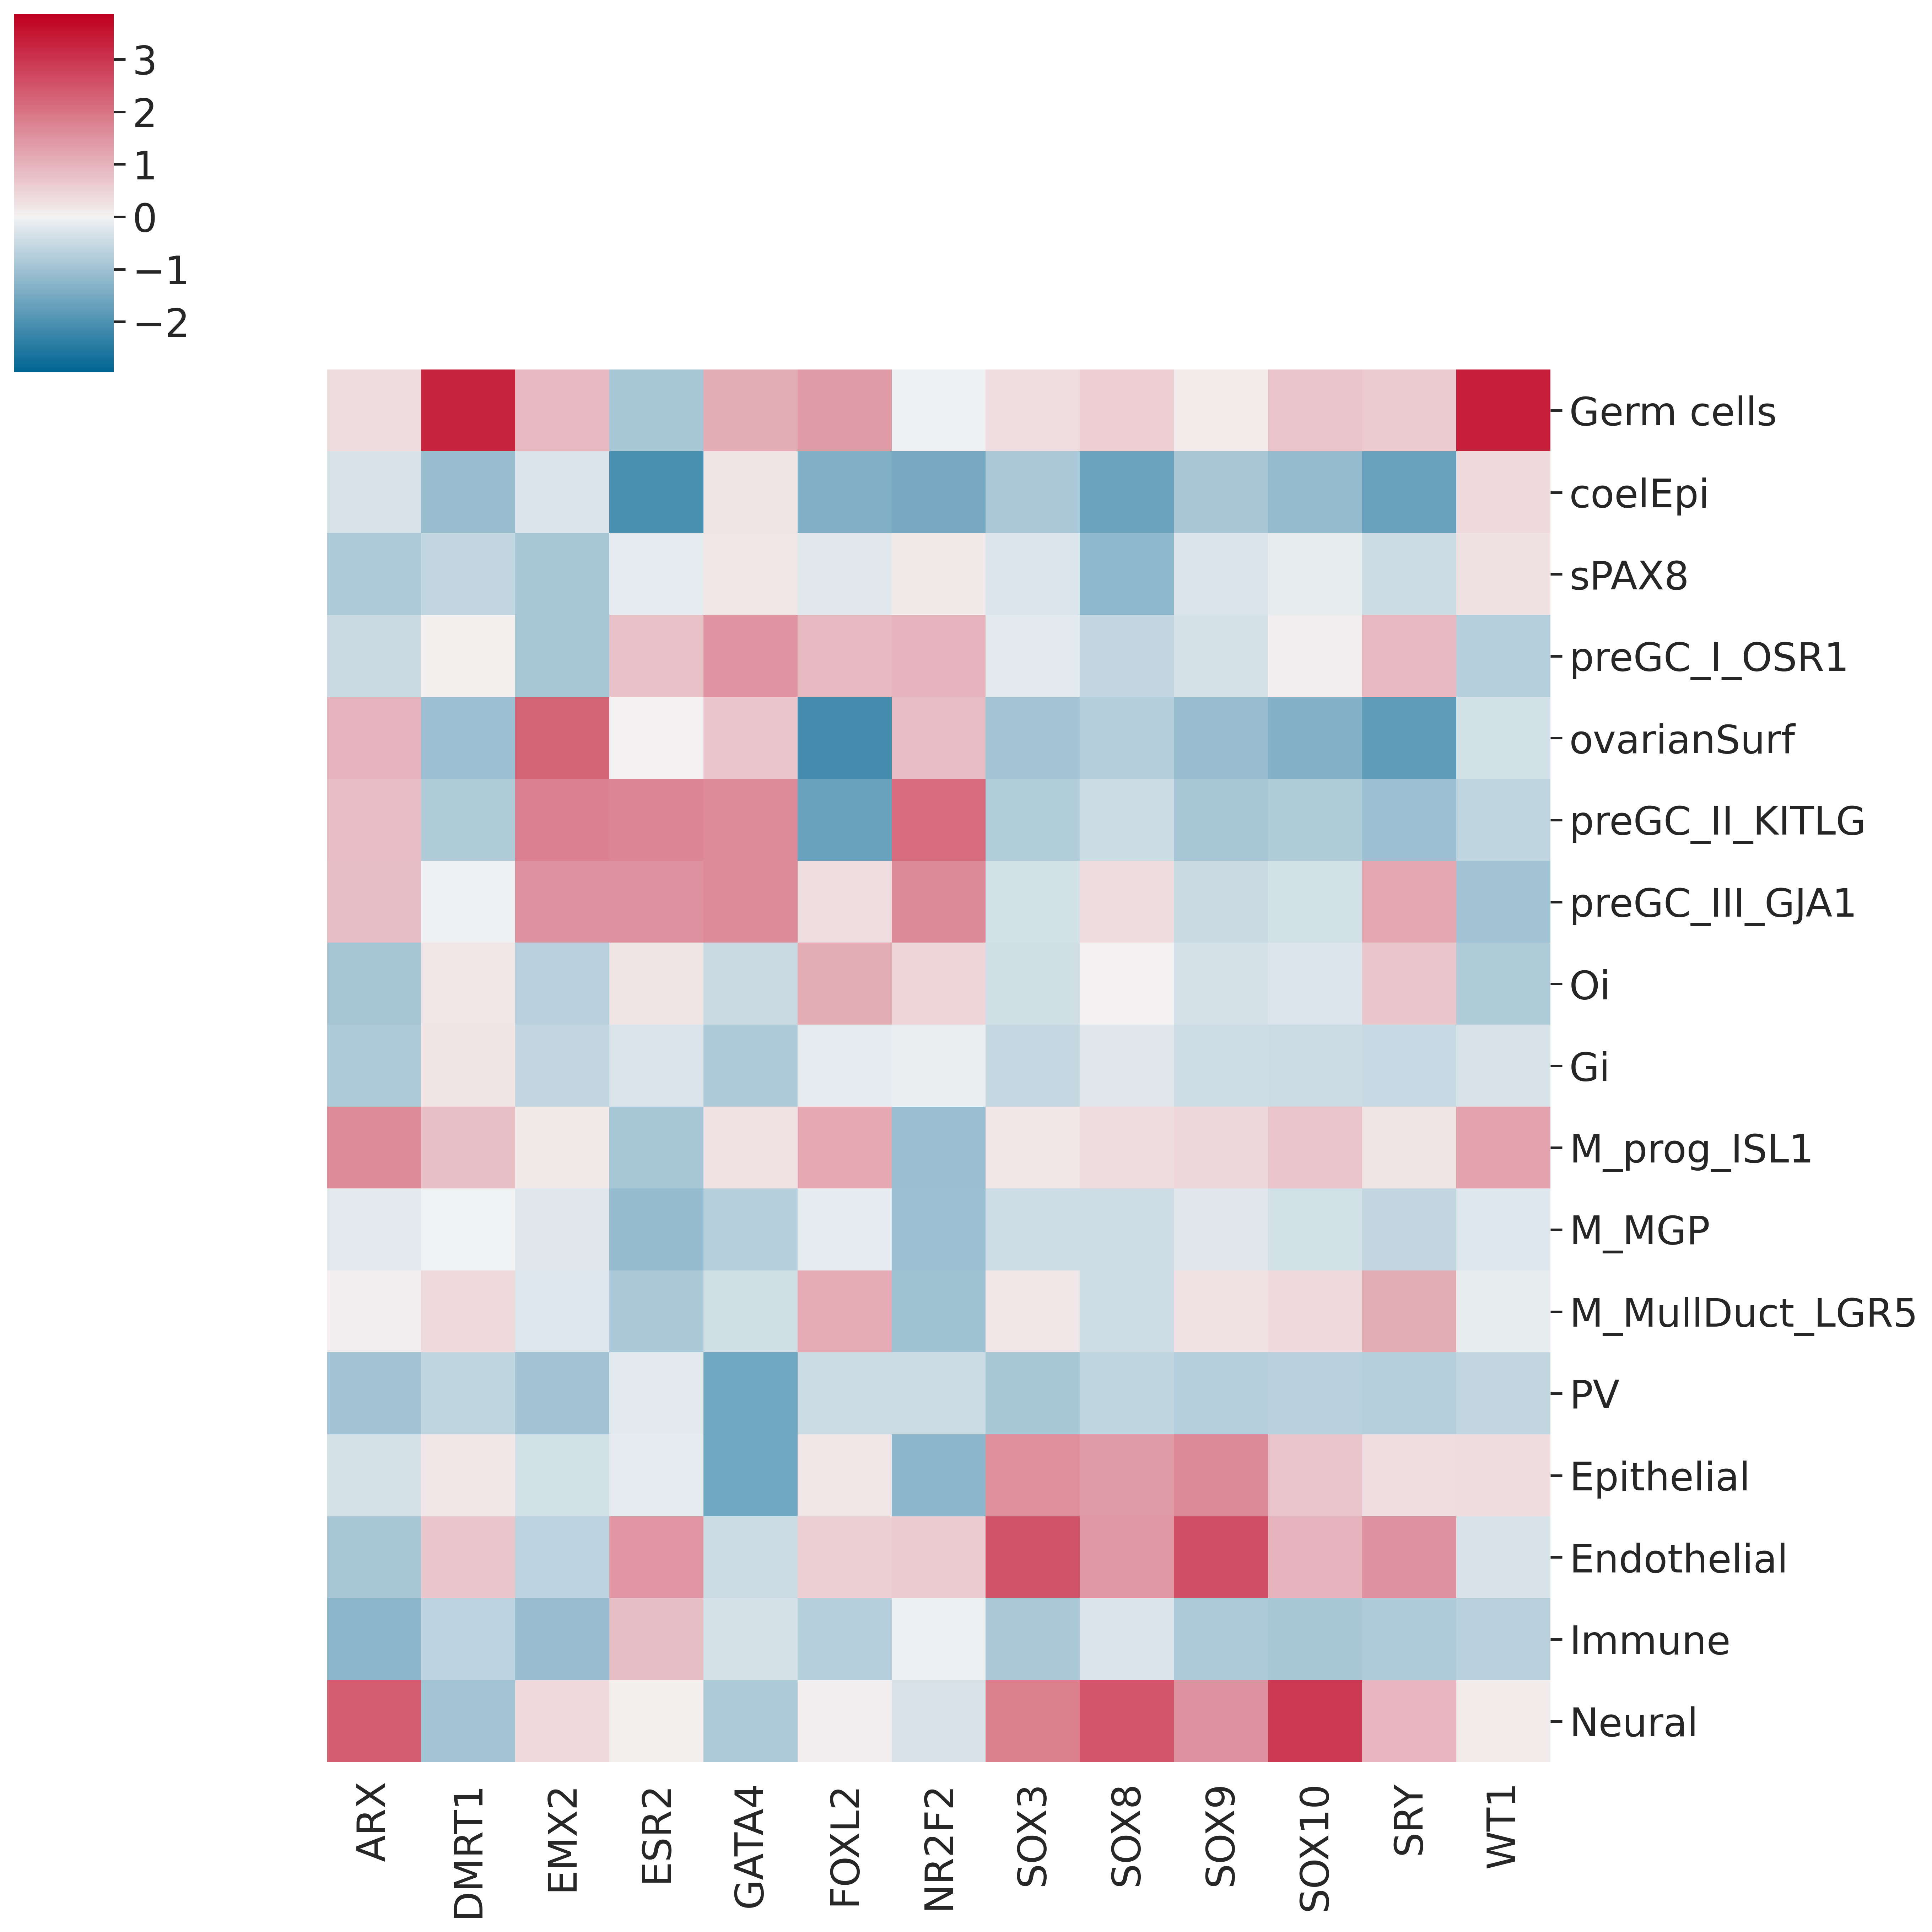

In [99]:
sns.set(font_scale=1.8)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_DSD, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(14, 14),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_females/DSD_TFs_heatmap.pdf")


#### End of notebook